In [18]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
import matplotlib.pyplot as plt

In [28]:

#y'' = sin(x)
def f(t):
    return (-np.exp(1)/(-np.exp(2)+1)*np.exp(t) + np.exp(1)/(-np.exp(2)+1)*np.exp(-t))
    
n = 1000
X = np.linspace(0,5,n)
y = f(X)


In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

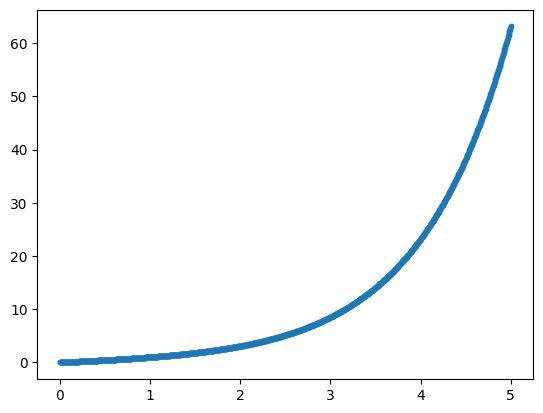

In [30]:
plt.scatter(X, y, s = 10)

In [50]:
model = keras.Sequential([
    keras.layers.Dense(100, activation = 'tanh', kernel_initializer = 'random_normal', input_shape = (1,)),
    keras.layers.Dense(1)  
])

In [51]:
optimizer = 2
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = 'accuracy' )

7/7 [==============================] - 0s 2ms/step


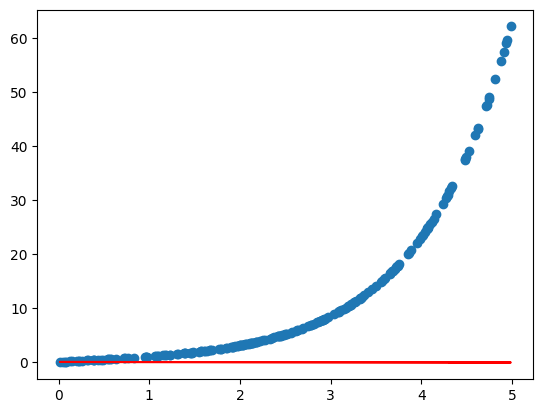

In [52]:
plt.plot(X_test, model.predict(X_test), color = 'red') #initial guess
plt.scatter(X_test, y_test)


In [53]:
e = 1000
X_train = X_train.reshape(-1,1)
model.fit(X_train, y_train, epochs=e)

Epoch 1/1000
25/25 [==============================] - 0s 512us/step - loss: 399.7758 - accuracy: 0.0012
Epoch 2/1000
25/25 [==============================] - 0s 534us/step - loss: 353.3696 - accuracy: 0.0000e+00
Epoch 3/1000
25/25 [==============================] - 0s 493us/step - loss: 307.0963 - accuracy: 0.0000e+00
Epoch 4/1000
25/25 [==============================] - 0s 448us/step - loss: 256.2508 - accuracy: 0.0000e+00
Epoch 5/1000
25/25 [==============================] - 0s 586us/step - loss: 214.4026 - accuracy: 0.0000e+00
Epoch 6/1000
25/25 [==============================] - 0s 579us/step - loss: 182.6408 - accuracy: 0.0000e+00
Epoch 7/1000
25/25 [==============================] - 0s 841us/step - loss: 163.7286 - accuracy: 0.0000e+00
Epoch 8/1000
25/25 [==============================] - 0s 823us/step - loss: 152.2906 - accuracy: 0.0000e+00
Epoch 9/1000
25/25 [==============================] - 0s 627us/step - loss: 145.3088 - accuracy: 0.0000e+00
Epoch 10/1000
25/25 [===========

7/7 [==============================] - 0s 550us/step
200
200


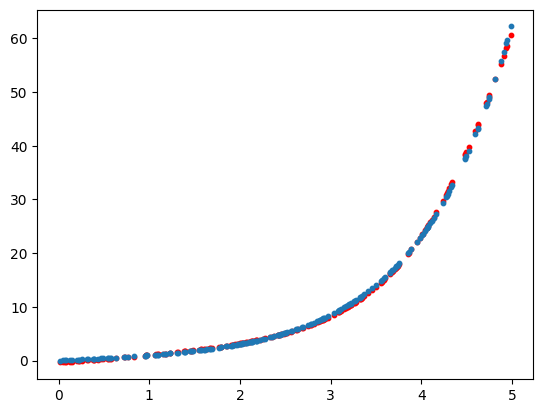

In [56]:
y_hat = model.predict(X_test)
y_hat = y_hat.reshape(-1,1)
print(len(y_hat))
print(len(X_test))
# Ensure X_test is in the same shape as y_hat for plotting
if len(X_test.shape) > 1:
    X_test = X_test.squeeze()

plt.scatter(X_test, y_hat, color='red', s=10)
plt.scatter(X_test, y_test, s=10)
plt.show()
